# Predictive Model for Employee Retention Prediction
* Business Objective
* Data Collection and Understanding
* Exploratory Data Analysis
* Data Preparation
* Predictive Modeling
* Solutions

## 1. Business Objective: 
* Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. (people analytics or people data science)
* The goal of this project is to predict employee retention and understand its main drivers.
* The tasks for this challenge:
    * Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. You should create a table with 3 columns: day, employee_headcount, company_id.
    * What are the main factors that drive employee churn? Do they make sense? Explain your ﬁndings.
    * If you could add to this data set just one variable that could help explain employee churn, what would that be?

## 2. Data Collection and Understanding

In [1]:
# Read in the dataset
import pandas as pd
import numpy as np
import pandas_profiling
data = pd.read_csv('employee_retention_data.csv')

In [2]:
# Overview for the dataset and variables
pandas_profiling.ProfileReport(data)

Number of variables,7
Number of observations,24702
Total Missing (%),6.5%
Total size in memory,1.3 MiB
Average record size in memory,56.0 B
Numeric,4
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [3]:
# Look at the first few rows of the dataset
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


#### Data Dictionary:
* employee_id : id of the employee. Unique by employee per company 
* company_id : company id.
* dept : employee dept 
* seniority : number of yrs of work experience when hired 
* salary: avg yearly salary of the employee during her tenure within the company 
* join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 
* quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this ﬁeld is NA)

In [4]:
# Look at the information for the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
# Check number of missing values for the dataset
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [6]:
# Check duplicates in the dataset
data.duplicated().sum()

0

#### Summary from Data Understanding:
* No duplicates
* Missing values for quit_date indicate the employees are still employed on that day.
* Need to do some variable reformatting

## 3. Exploratory Data Analysis:
* Univariate visualization and summary statistics for each field in the raw dataset
* Bivariate visualization and summary statistics for assessing the relationship between each variable in the dataset and the target variable
* Multivariate visualizations to understand interactions between different fields in the data
* Feature Engineering: use domain knowledge to create additional relevant features from the existing raw features in the data, and to increase the predictive power of the learning algorithm

In [7]:
# Import python modules for visualization
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set_style('whitegrid')

### 3.1 Univariate Analysis

#### 3.1.1 Numerical variables

In [8]:
# Summary for numerical variables
print(data.describe(include=['int64','float64']))

         employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530      3.426969     14.127803  138183.345478
std    288909.026101      2.700011      8.089520   76058.184573
min        36.000000      1.000000      1.000000   17000.000000
25%    250133.750000      1.000000      7.000000   79000.000000
50%    500793.000000      2.000000     14.000000  123000.000000
75%    753137.250000      5.000000     21.000000  187000.000000
max    999969.000000     12.000000     99.000000  408000.000000


In [9]:
# employee_id and company_id
data.employee_id.nunique(), data.company_id.nunique()

(24702, 12)

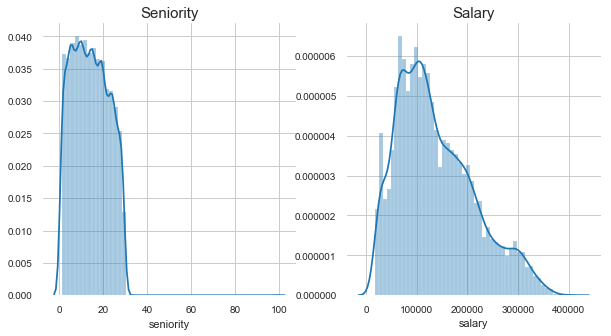

In [10]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

seaborn.distplot(data.seniority, ax=axarr[0])
axarr[0].set_title("Seniority", fontsize=15)

seaborn.distplot(data.salary, ax=axarr[1])
axarr[1].set_title("Salary", fontsize=15)

plt.subplots_adjust(hspace=.3)

seaborn.despine()

#### 3.1.2 Categorical variables

In [11]:
# Summary for categorical variables
print(data.describe(include=['object']))

                    dept   join_date   quit_date
count              24702       24702       13510
unique                 6         995         664
top     customer_service  2012-01-03  2015-05-08
freq                9180         105         111


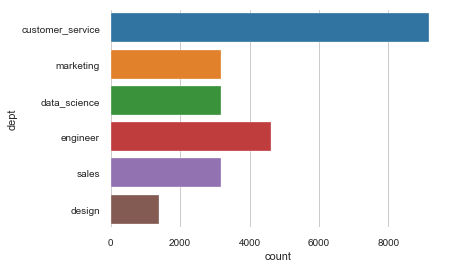

In [12]:
# Department
seaborn.countplot(y='dept', data=data)

In [13]:
# join_date and quit_date
data.join_date = pd.to_datetime(data.join_date)
data.quit_date = pd.to_datetime(data.quit_date)

In [14]:
data[['join_date', 'quit_date']].describe()

,join_date,quit_date
count,24702,13510
unique,995,664
top,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,105,111
first,2011-01-24 00:00:00,2011-10-13 00:00:00
last,2015-12-10 00:00:00,2015-12-09 00:00:00


### 3.2 Feature Engineering

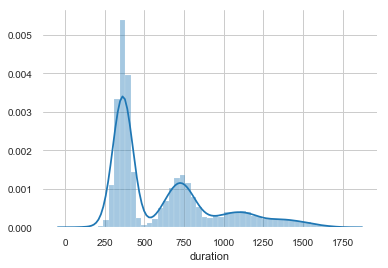

In [15]:
# Calculate employment duration as difference between join_date and quit_date
data['duration'] = (data['quit_date'] - data['join_date']).astype('timedelta64[D]')
seaborn.distplot(data['duration'].dropna())

From the distribution plot, we can see peaks around the employment anniversaries.

In [16]:
# Remove those who joined the company less than 2 years ago (from 2015/12/13) since they didn't have enough time to age
from datetime import timedelta
data1 = data[data['join_date'] < pd.Timestamp(year=2015, month=12, day=13) - timedelta(days=(365*2))]
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14633 entries, 1 to 24701
Data columns (total 8 columns):
employee_id    14633 non-null float64
company_id     14633 non-null int64
dept           14633 non-null object
seniority      14633 non-null int64
salary         14633 non-null float64
join_date      14633 non-null datetime64[ns]
quit_date      11511 non-null datetime64[ns]
duration       11511 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 1.0+ MB


In [17]:
# Define employment status: 1 for early quitter (<2yrs), 0 for non_early quitter or happy employee
data1['early_quitter'] = np.where(data1.duration < 365*2, 1, 0)
data1['early_quitter'].value_counts()

/Users/cloris1022/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    7377
1    7256
Name: early_quitter, dtype: int64

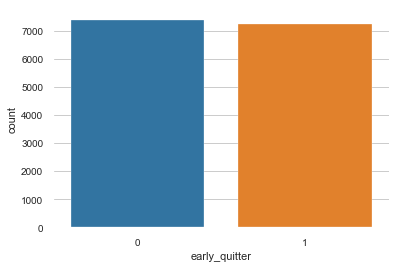

In [18]:
seaborn.countplot(data1['early_quitter'])

In [19]:
# Check extreme values for seniority: >90 years of serniority seems not normal
seniority_outlier = data1[data1['seniority']>40]
seniority_outlier

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,early_quitter
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123.0,0
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,864.0,0


In [20]:
# Drop seniority outlier
data1.drop(seniority_outlier.index, axis=0, inplace=True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14631 entries, 1 to 24699
Data columns (total 9 columns):
employee_id      14631 non-null float64
company_id       14631 non-null int64
dept             14631 non-null object
seniority        14631 non-null int64
salary           14631 non-null float64
join_date        14631 non-null datetime64[ns]
quit_date        11509 non-null datetime64[ns]
duration         11509 non-null float64
early_quitter    14631 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(3), object(1)
memory usage: 1.1+ MB


/Users/cloris1022/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### 3.3 Bivariate and Multivariate Analysis

#### 3.3.1 Bivariate Analysis

In [21]:
# Correlation matrix
data1.corr()

,employee_id,company_id,seniority,salary,duration,early_quitter
employee_id,1.000000,-0.013220,0.001836,0.007702,0.010938,-0.001575
company_id,-0.013220,1.000000,-0.009288,-0.161210,-0.016377,0.024977
seniority,0.001836,-0.009288,1.000000,0.560681,-0.000160,0.007513
salary,0.007702,-0.161210,0.560681,1.000000,0.080223,-0.073527
duration,0.010938,-0.016377,-0.000160,0.080223,1.000000,-0.835493
early_quitter,-0.001575,0.024977,0.007513,-0.073527,-0.835493,1.000000


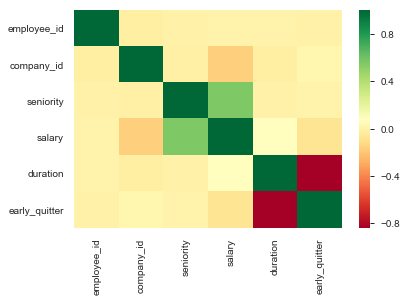

In [22]:
# Heatmap for correlation
seaborn.heatmap(data1.corr(),cmap='RdYlGn')

Retention (early_quitter) is negatively related to duration; salary and seniority are highly related.

#### 3.3.2 Bivariate relationship with the target variable

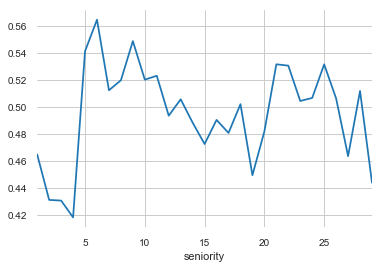

In [23]:
# seniority vs retention
data1.groupby(['seniority'])['early_quitter'].mean().plot.line()
plt.show()

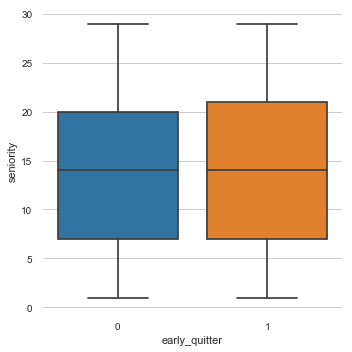

In [24]:
seaborn.catplot(x='early_quitter', y='seniority', kind='box', data=data1)

Employees are more likely to quit early around their 5th year seniority, and decreased at high seniority, with fluctuations in the middle.

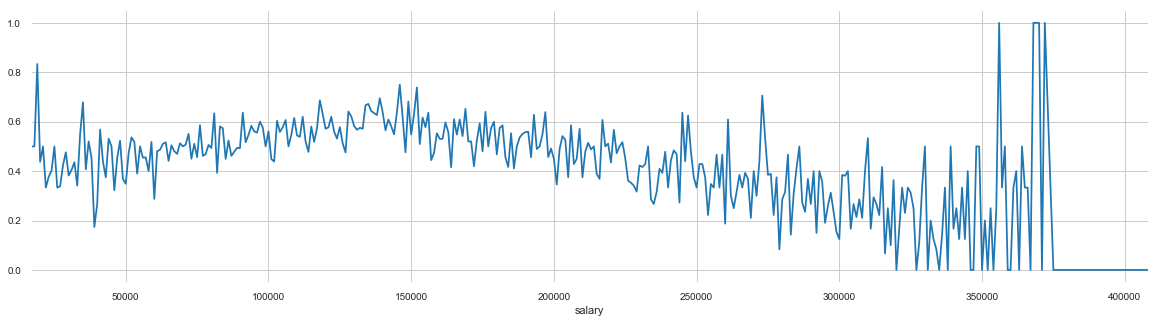

In [25]:
# salary vs retention
fig, ax = plt.subplots(figsize=(20,5))
data1.groupby(['salary'])['early_quitter'].mean().plot.line()
plt.show()

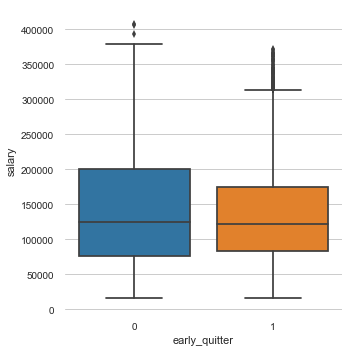

In [26]:
seaborn.catplot(x='early_quitter', y='salary', kind='box', data=data1)

Early quitting is less likely to occur at the lower salary range and higher salary range. 

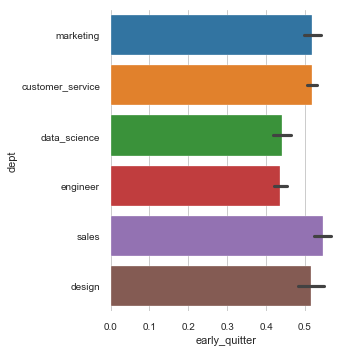

In [27]:
# dept vs retention
seaborn.catplot(y='dept', x='early_quitter', kind='bar', data=data1)

Employees in the engineer and data science departments are more likely to stay longer than other departments like sales and design.

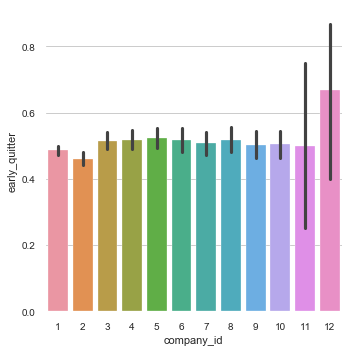

In [28]:
# company vs retention
seaborn.catplot(x='company_id', y='early_quitter', kind='bar', data=data1)

#### 3.3.3 Multivariate relationship among variables

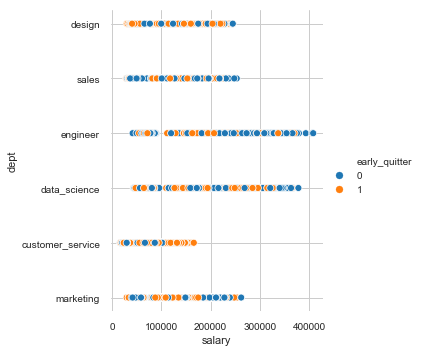

In [29]:
# dept / salary / retention
seaborn.relplot(y='dept', x='salary', hue='early_quitter', data=data1)

Employees in the engineer and data science departments have higher salary than others, and employee retention is higher at the higher salary range.

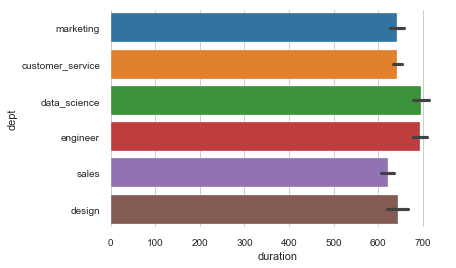

In [30]:
# dept vs duration
seaborn.barplot(y='dept', x='duration', data=data1)

Employees in data science and engineer stay longer than others.

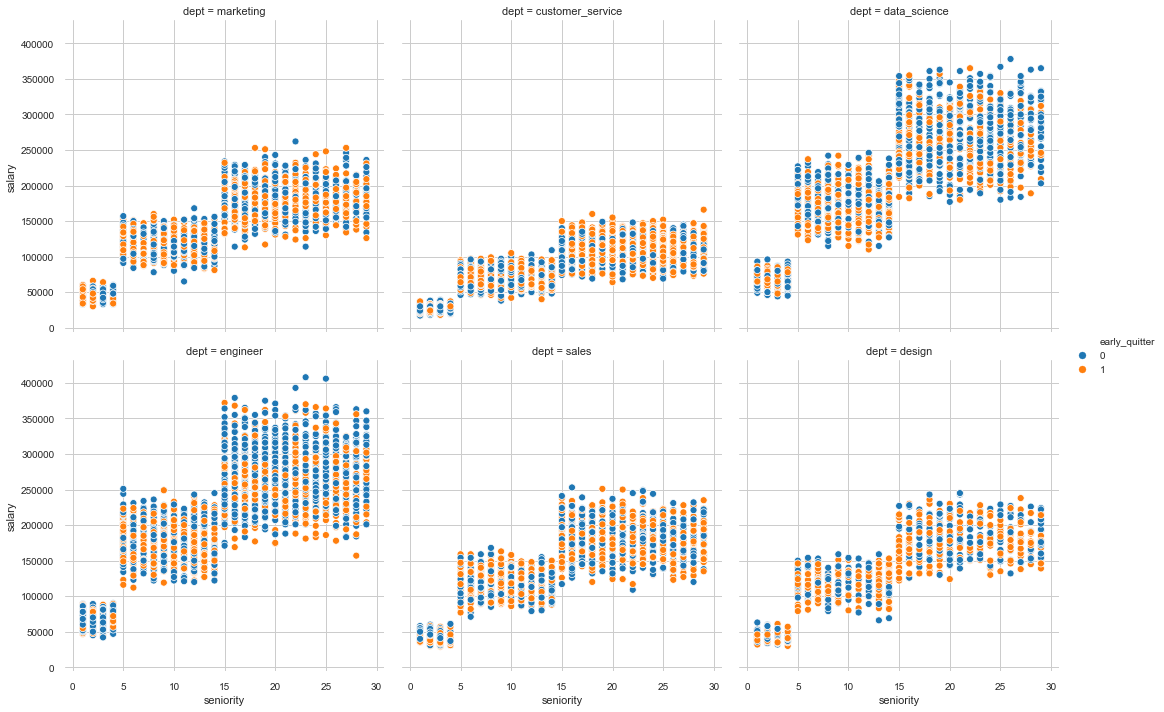

In [31]:
# seniority / salary / retention
seaborn.relplot(x='seniority', y='salary', hue='early_quitter', col='dept', col_wrap=3, data=data1)

Salary is not linearly related to seniority, the retention rate is affected by seniority and salary also vary by department.

## 4. Data Preparation:
* Data Cleaning: 
    * Check missing, duplicated, incorrect values (None here)
    * Getting dummies for categorical variables
* Feature Selection / Dimensionality Reduction: to understand the fields in the data that account for the most variance between observations and allow for the processing of a reduced volume of data

### 4.1 Data Cleaning

In [32]:
# Get dummies for the categorical variables
data2 = pd.get_dummies(data1, drop_first = True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14631 entries, 1 to 24699
Data columns (total 13 columns):
employee_id          14631 non-null float64
company_id           14631 non-null int64
seniority            14631 non-null int64
salary               14631 non-null float64
join_date            14631 non-null datetime64[ns]
quit_date            11509 non-null datetime64[ns]
duration             11509 non-null float64
early_quitter        14631 non-null int64
dept_data_science    14631 non-null uint8
dept_design          14631 non-null uint8
dept_engineer        14631 non-null uint8
dept_marketing       14631 non-null uint8
dept_sales           14631 non-null uint8
dtypes: datetime64[ns](2), float64(3), int64(3), uint8(5)
memory usage: 1.7 MB


### 4.2 Feature Selection

In [33]:
# Define training data and target variable - retention
train_data = data2.drop(columns = ['early_quitter', 'employee_id', 'join_date', 'quit_date', 'duration'],axis=1)
target = data2['early_quitter']
train_data.shape, target.shape

((14631, 8), (14631,))

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14631 entries, 1 to 24699
Data columns (total 8 columns):
company_id           14631 non-null int64
seniority            14631 non-null int64
salary               14631 non-null float64
dept_data_science    14631 non-null uint8
dept_design          14631 non-null uint8
dept_engineer        14631 non-null uint8
dept_marketing       14631 non-null uint8
dept_sales           14631 non-null uint8
dtypes: float64(1), int64(2), uint8(5)
memory usage: 1.1 MB


In [35]:
# Use random forest classifier for feature selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=25, n_estimators=100)
rfc.fit(train_data, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

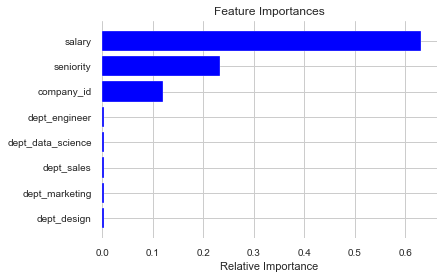

In [36]:
# Look at the top most important features
features = train_data.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From above, we can see the relative feature importance on how salary, seniority, company and department affect the retention (early quitter or not).

## 5. Predictive Modeling
* Train tree model
* Visualize decision tree

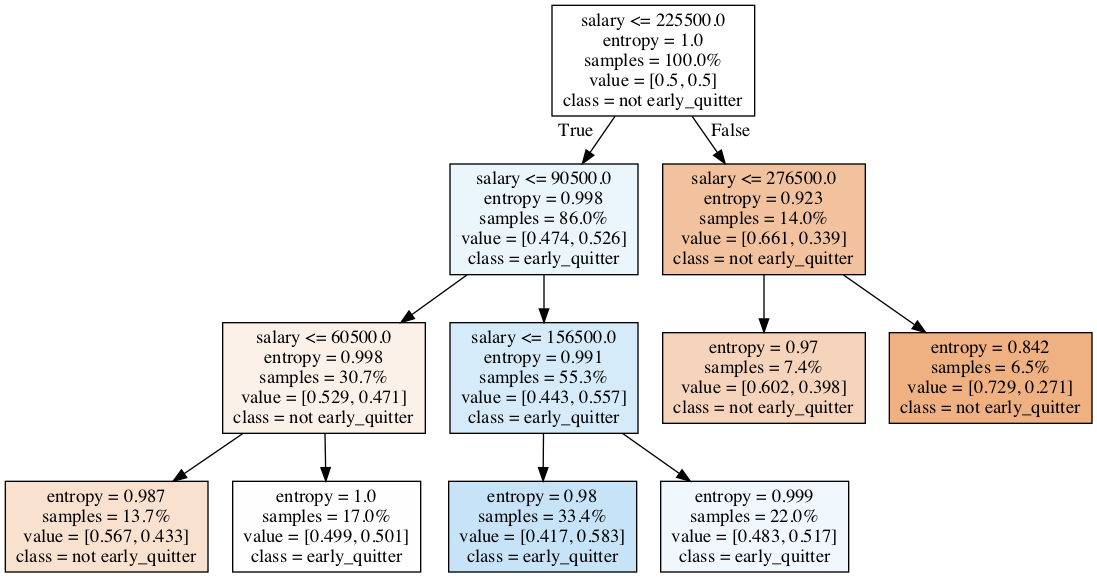

In [37]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import Image
import pydotplus
    
tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = 10, 
                              min_samples_split = 100,
                              min_samples_leaf = 100, 
                              class_weight="balanced", 
                              min_impurity_decrease = 0.001)
tree.fit(train_data, target)

dot_data = export_graphviz(tree, out_file=None, filled=True, proportion=True,
                           feature_names=train_data.columns, 
                           class_names=['not early_quitter', 'early_quitter'])

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

From the above, we can see salary plays a very important role on explaining the retention behavior.

Interpretation and findings: 
* Employees are LESS likely to quit early if:
    * salary no more than 60.5K
    * salary more than 225.5K
* Employees are MORE likely to quit early if:
    * salary between 60.5K and 225.5K

These make sense because employees with high income are happy and rewarding at work, and employees with very low income are not that marketable and competitive so they might not quit the current job early.

## 6. Solutions

### 6.1 Estimate employee headcount per company and day

In [38]:
# Create a DataFrame with dates and companies list
df_dates = pd.date_range(start='2011/01/24', end='2015/12/13')
df_companies = data['company_id'].unique()

# Construct a combined table from the cartesian product of unique dates and companies
df = pd.MultiIndex.from_product([df_dates, df_companies], names = ["day", "company_id"])
df = pd.DataFrame(index = df).reset_index()
df.head()

,day,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


In [39]:
# Get the number of employees join each company on each day
df_join = data1.groupby(['join_date', 'company_id']).size().reset_index(name='join_counts').rename(columns={'join_date':'day'})
df_join.head()

,day,company_id,join_counts
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [40]:
# Get the number of employees quit each company on each day
df_quit = data1.groupby(['quit_date', 'company_id']).size().reset_index(name='quit_counts').rename(columns={'quit_date':'day'})
df_quit.head()

,day,company_id,quit_counts
0,2011-10-13,6,1
1,2011-10-14,10,1
2,2011-10-21,1,1
3,2011-10-28,4,1
4,2011-11-11,1,1


In [41]:
# Merge the table with day, company_id, and join/quit counts
df_headcount = pd.merge(df, df_join, on=['day', 'company_id'], how='left')
df_headcount = pd.merge(df_headcount, df_quit, on=['day', 'company_id'], how='left')
df_headcount.fillna(0, inplace=True)
df_headcount.head(10)

,day,company_id,join_counts,quit_counts
0,2011-01-24,7,1.0,0.0
1,2011-01-24,4,12.0,0.0
2,2011-01-24,2,17.0,0.0
3,2011-01-24,9,3.0,0.0
4,2011-01-24,1,25.0,0.0
5,2011-01-24,6,3.0,0.0
6,2011-01-24,10,0.0,0.0
7,2011-01-24,5,5.0,0.0
8,2011-01-24,3,9.0,0.0
9,2011-01-24,8,6.0,0.0


In [42]:
# Calculate the headcount per day/company by taking the difference between the cumulative join counts and quit counts
df_headcount['join_counts_cum'] = df_headcount.groupby(['company_id'])['join_counts'].apply(lambda x: x.cumsum())
df_headcount['quit_counts_cum'] = df_headcount.groupby(['company_id'])['quit_counts'].apply(lambda x: x.cumsum())
df_headcount['employee_headcount'] = df_headcount['join_counts_cum'] - df_headcount['quit_counts_cum']
df_headcount.head()

,day,company_id,join_counts,quit_counts,join_counts_cum,quit_counts_cum,employee_headcount
0,2011-01-24,7,1.0,0.0,1.0,0.0,1.0
1,2011-01-24,4,12.0,0.0,12.0,0.0,12.0
2,2011-01-24,2,17.0,0.0,17.0,0.0,17.0
3,2011-01-24,9,3.0,0.0,3.0,0.0,3.0
4,2011-01-24,1,25.0,0.0,25.0,0.0,25.0


In [43]:
# Create table for the employee headcount per day and company
headcount_table = df_headcount[['day', 'company_id', 'employee_headcount']]

# Look at the employee headcount info for company 7
headcount_table.query('company_id==7')

,day,company_id,employee_headcount
0,2011-01-24,7,1.0
12,2011-01-25,7,1.0
24,2011-01-26,7,1.0
36,2011-01-27,7,1.0
48,2011-01-28,7,1.0
60,2011-01-29,7,1.0
72,2011-01-30,7,1.0
84,2011-01-31,7,7.0
96,2011-02-01,7,7.0
108,2011-02-02,7,7.0


### 7.2 Main factors that drive employee churn

From the model analysis:
* Salary is the most significant factor that influnces employee's retention.
* Department and Seniority also affect the retention rate of employees.

### 7.3  More features to explain employee's retention

I would consider the following features for explaining employee's turnover:
* Career development opportunities: 
    * Quality of training
    * Frequency of Promotion and raises
* Work-life balance: Workplace flexibility
* Employee's work Performance (in score or %)